In [1]:
# Install transformers from the PR branch until it's merged!
!pip install -q -U git+https://github.com/baptiste-aubertin/transformers.git@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
import torch
from PIL import Image
# from transformers import AutoProcessor, LightOnOCRForConditionalGeneration
from transformers.models.lighton_ocr.modeling_lighton_ocr import LightOnOcrForConditionalGeneration
from io import BytesIO

# Load Model
model_id = "../LightOnOCR-1B-1025"
device = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(model_id)
model = LightOnOcrForConditionalGeneration.from_pretrained(model_id, dtype=torch.bfloat16, device_map=device, attn_implementation="sdpa")
model.eval();

You are using a model of type mistral3 to instantiate a model of type lighton_ocr. This is not supported for all configurations of models and can yield errors.
Loading weights: 100%|██████████| 533/533 [00:02<00:00, 257.14it/s, Materializing param=model.vision_projection.patch_merger.merging_layer.weight]               
The tied weights mapping and config for this model specifies to tie model.language_model.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


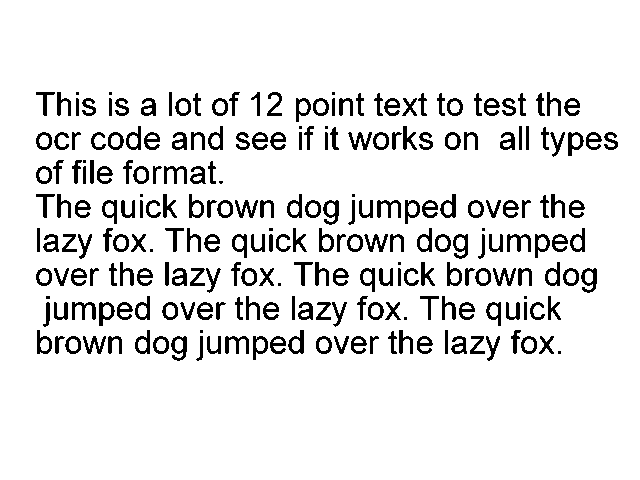

AttributeError: 'PixtralImageProcessorFast' object has no attribute 'apply_chat_template'

In [7]:
import requests
# Get a test image
image_url = "https://jeroen.github.io/images/testocr.png"
response = requests.get(image_url)
image = Image.open(BytesIO(response.content)).convert("RGB")

display(image)

# Run inference
messages = [{"role": "user", "content": [{"type": "image"}]}]
text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

inputs = processor(text=[text], images=[image], return_tensors="pt").to(device)
inputs["pixel_values"] = inputs["pixel_values"].to(torch.bfloat16)

outputs = model.generate(
    **inputs,
    max_new_tokens=1024,
)

input_length = inputs['input_ids'].shape[1]
generated_text = processor.tokenizer.decode(outputs[0, input_length:], skip_special_tokens=True)

print("============\n")
print(generated_text)